# Spike Report
## Introduction
In this tutorial we cover how to inspect a spike report using BlueBrain SNAP and access its properties.

We start by importing the `bluepysnap` package:

In [1]:
import bluepysnap

## Loading
In order to load the simulation data, we need the path to the file.

In [2]:
from bluepyentity.nexus import NexusHelper
from bluepyentity.token import get_token

nexus = NexusHelper(token=get_token('production'), bucket='nse/test2')
simulation_id = 'https://bbp.epfl.ch/nexus/v1/resources/nse/test2/_/ec23054c-57cb-4095-b1ec-ae39dfacb205'
simulation_entity = nexus.get_entity_by_id(simulation_id)
simulation_path = simulation_entity.simulationConfigPath.url.replace('file://', '')

Token:  ································································································································································································································································································································································································································································································································································································································································································································································································································································································································································································································

For the above to work, `bluepyentity` needs to be installed

We can now open the simulation:

In [3]:
simulation = bluepysnap.Simulation(simulation_path)

Accessing simulation spike report is straightforward

In [4]:
spikes = simulation.spikes

## Timing

As with the `Simulation` instance, it's easy to access report start and end time, as well as the time step (dt)

In [5]:
print(
    spikes.time_start, 
    spikes.time_stop, 
    spikes.dt
)

0 100.0 0.025


## Populations
If we are interested in the populations in spike report, they can be shown with

In [6]:
spikes.population_names

['thalamus_neurons']

And when we know the population name, accessing it in the report is done as in the case of node/edge populations

In [7]:
spike_pop = spikes['thalamus_neurons']
print(type(spike_pop))

<class 'bluepysnap.spike_report.PopulationSpikeReport'>


If we want to access the actual NodePopulation instance from the report, it can also be done

In [8]:
dir(spike_pop)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_population_name',
 '_resolve_nodes',
 '_sorted_by',
 '_spike_population',
 'get',
 'name',
 'node_ids',
 'nodes',
 'spike_report']

In [9]:
simulation.circuit

In [10]:
node_population = spike_pop.nodes
print(f'{node_population.name}: {type(node_population)}')

thalamus_neurons: <class 'bluepysnap.nodes.NodePopulation'>


## Node IDs
Now that we are familiar with the basics, accessing the node_ids in the report and getting their info is as easy as

In [11]:
ids = spike_pop.node_ids
node_population.get(ids, properties=['layer','synapse_class','x','y','z']).head()

,layer,synapse_class,x,y,z
28606,Rt,INH,171.278717,595.117554,830.635132
28608,Rt,INH,206.739487,586.587280,811.247925
28610,Rt,INH,187.273773,584.099487,847.822693
28613,Rt,INH,195.624069,580.239441,827.660034
28614,Rt,INH,191.636215,559.752747,834.632874


## Filtering
We can filter the report to only access the data we are interested in

In [12]:
filtered = spikes.filter(group={'layer':'VPL'}, t_start=1, t_stop=100)
filtered.report.head()

,ids,population
times,,
10.775,42498,thalamus_neurons
11.025,42507,thalamus_neurons
11.675,42465,thalamus_neurons
12.400,42470,thalamus_neurons
12.600,42468,thalamus_neurons


## Plotting
We may also want to visualize data. Plotting raster plot of filtered spikes:

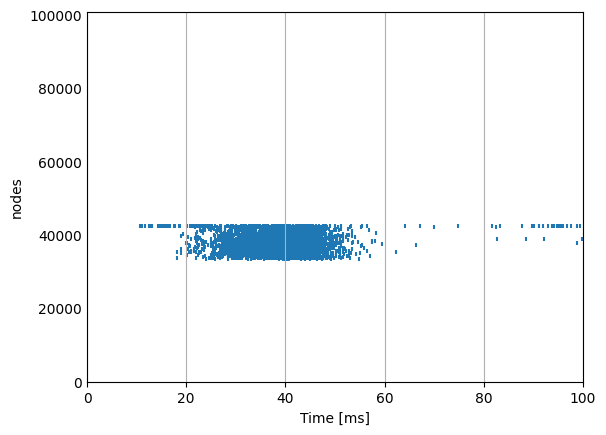

In [13]:
filtered.raster();

Plotting a firing rate histogram of the filtered spikes:

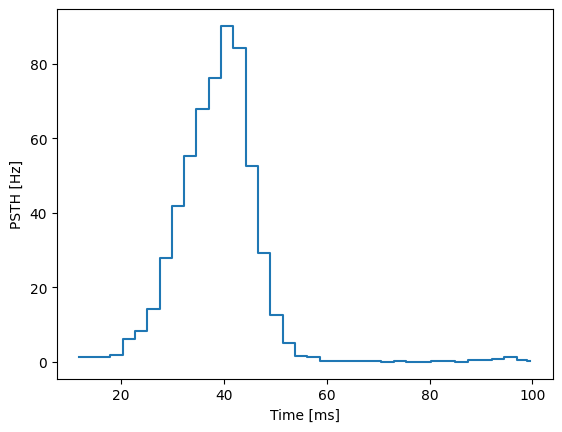

In [14]:
filtered.firing_rate_histogram();

Only filtered reports have plotting cababilities. However, filters can be called without arguments which leads to the filtered object having all the available data

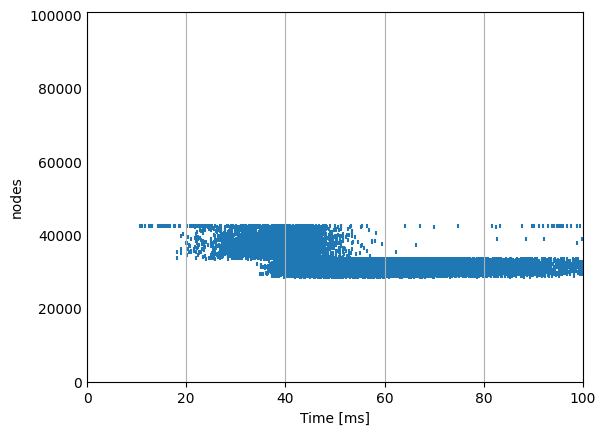

In [15]:
spikes.filter().raster();

It might also be useful to change the y-axis to e.g., m-type

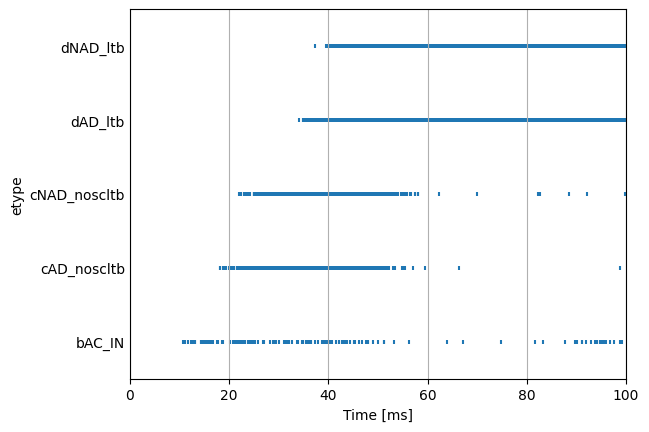

In [16]:
spikes.filter().raster(y_axis='etype');

One can also plot interspike interval plot

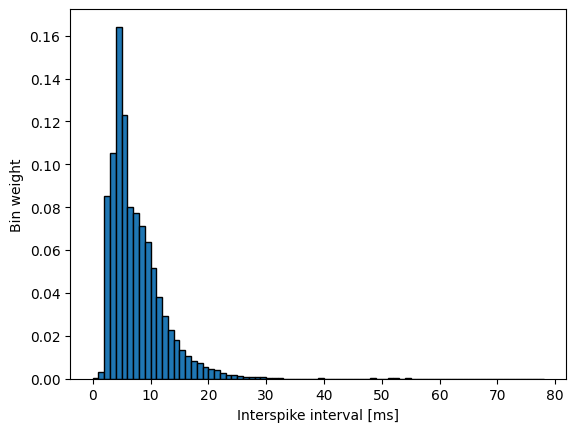

In [17]:
spikes.filter().isi(binsize=1);

## Reading the log
The `SpikeReport.log()` yields a file handler for the log file (raises error if log file not found). It can be read like any file in python:

In [18]:
with spikes.log() as l:
    print(" ...")
    print(*l.readlines()[:10])
    print(" ...")

 ...
[STEP] (Jun.07 15:43:14) Initializing Neurodamus... Logfile: pydamus_2022-06-07_15h43.log
 [INFO] (Jun.07 15:43:14)  => Neurodamus Mod & Hoc lib loaded.
 [INFO] (Jun.07 15:43:14) Checking for plugins...
 [INFO] (Jun.07 15:43:14)  => Engines Available: ['Base', 'NGV', 'PointNeuron', 'METype']
 [INFO] (Jun.07 15:43:14)   : Connections Types: ['NeuroGlial', 'GlioVascular', 'Point', None, 'Synaptic', 'GapJunction', 'NeuroModulation']
 [STEP] (Jun.07 15:43:14) Setting up Neurodamus configuration
 [INFO] (Jun.07 15:43:14) Initializing Simulation Configuration and Validation
 [WARNING] (Jun.07 15:43:14) Unhandled synapse type: chemical
 [INFO] (Jun.07 15:43:15) Checking simulation requirements
 [INFO] (Jun.07 15:43:15) Initializing hoc config objects

 ...


## Conclusion
We introduced how spike reports can be accessed and plotted with `bluepysnap`. Next we'll take a look into the frame reports.